In [1]:
import numpy as np
import matplotlib.pyplot as plt
import audacity
%matplotlib notebook

In [2]:
rpmvals = ['4050','4250','4500','4750','5000']
SENSITIVITY = 0.000316
RUNS = 3

dfiles = []
for rpm in rpmvals:
    for r in range(RUNS):
        dfiles.append('DATA/MAIN_4500rpm/calibration/cross/%srpm_%d.aup'%(rpm,r))

In [3]:
### Functions - Andre

def RMSWind(x, sr=1, nwind=1024, nhop=512, windfunc=np.blackman):
    '''
    Calculates the RMS amplitude of x, in frames of
    length nwind, and in steps of nhop. windfunc is used as
    windowing function.
    nwind should be at least 3 periods if the signal is periodic.
    '''

    nsam = len(x)
    ist = 0
    iend = ist+nwind

    t = []
    ret = []

    wind = windfunc(nwind)
    wsum2 = np.sum(wind**2)

    while (iend < nsam):
        thisx = x[ist:iend]
        xw = thisx*wind

        ret.append(np.sum(xw*xw/wsum2))
        t.append(float(ist+iend)/2.0/float(sr))

        ist = ist+nhop
        iend = ist+nwind

    return np.sqrt(np.array(ret)), np.array(t)

In [4]:
amplitude = []
pressure = []
for file in dfiles:
    auf = audacity.Aup(file)
    sr = auf.rate
    data = auf.get_channel_data(0)[int(5*sr):]
    ann = auf.get_annotation_data()[0]['label']
    maxrms, maxt = RMSWind(data, sr=sr)
    maxvals = [m*np.sqrt(2) for m in maxrms]
    minrms, mint = RMSWind(np.negative(data), sr=sr)
    minvals = [np.negative(m)*np.sqrt(2) for m in minrms]
    meanmax = np.mean(maxvals)
    meanmin = np.mean(minvals)
    App = meanmax-meanmin
    Vpp = float(ann)
    Pa = Vpp/SENSITIVITY
    amplitude.append(App)
    pressure.append(Pa)
#     plt.figure()
#     plt.plot(data)
#     plt.plot(mint*sr, minvals)
#     plt.plot(maxt*sr, maxvals)
#     plt.plot(mint*sr, [meanmin for m in mint])
#     plt.plot(maxt*sr, [meanmax for m in maxt])  


# amplitude = sorted(amplitude)
# pressure = sorted(pressure)

In [5]:
(ar,br) = np.polyfit(amplitude,pressure,1)
yr = np.polyval([ar,br],amplitude)
err = np.sqrt(sum((yr-pressure)**2)/len(pressure))

<IPython.core.display.Javascript object>


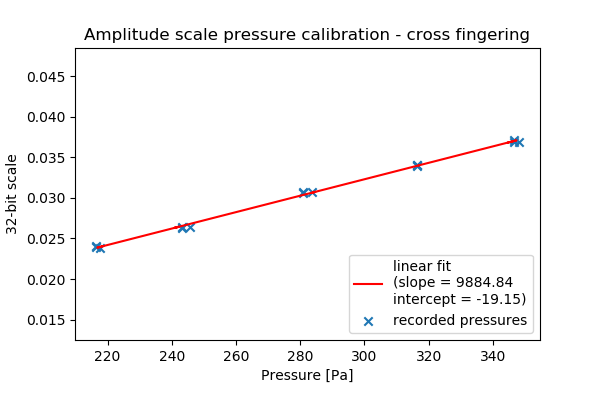

In [7]:
plt.figure(figsize=(6,4))
plt.title('Amplitude scale pressure calibration - cross fingering')
plt.scatter(pressure, amplitude, marker='x',
           label='recorded pressures')
plt.plot(yr, amplitude, c='r', 
         label='linear fit \n(slope = %.2f \nintercept = %.2f)' %(ar,br))
plt.legend(loc='lower right')
plt.xlabel('Pressure [Pa]')
plt.ylabel('32-bit scale')
plt.subplots_adjust(bottom=0.15)
# plt.savefig('Pcalib_cross.png')

<IPython.core.display.Javascript object>


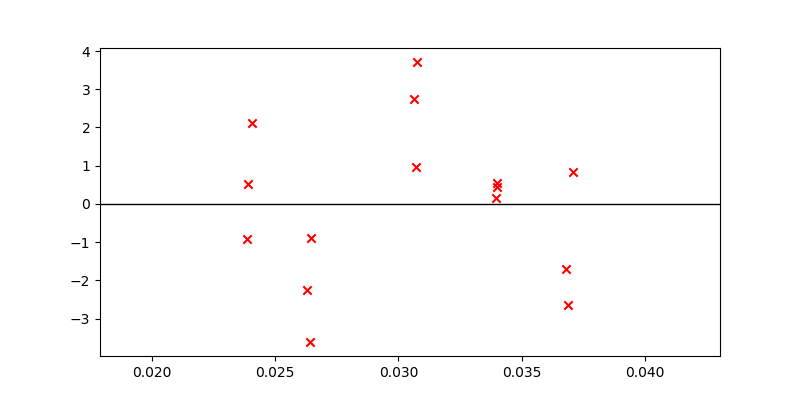

In [8]:
plt.figure('Residuals', figsize=(8,4))
plt.scatter(amplitude, yr-pressure, c='r', marker='x')
plt.axhline(0, color='k', linewidth=1)